Columnas categóricas detectadas: Index(['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment',
       'distribution_channel', 'reserved_room_type', 'assigned_room_type',
       'deposit_type', 'customer_type', 'reservation_status',
       'reservation_status_date'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights 

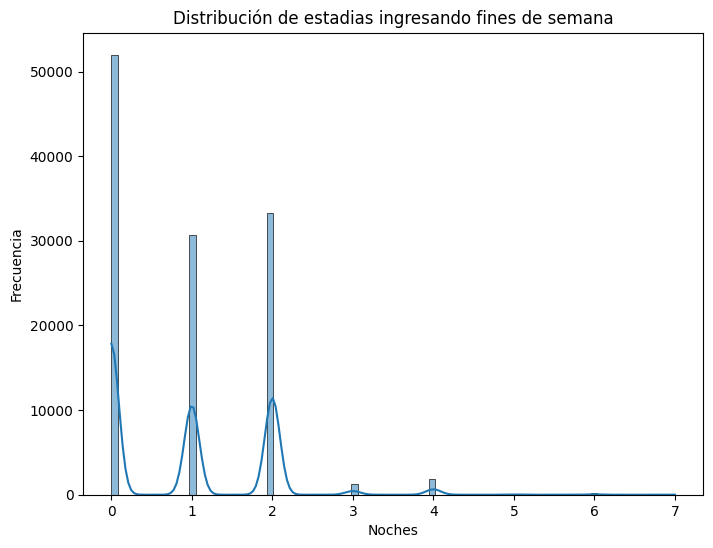

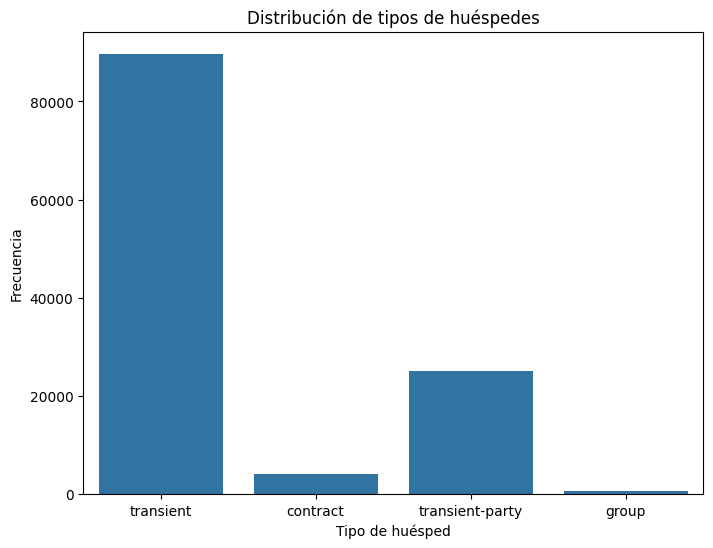

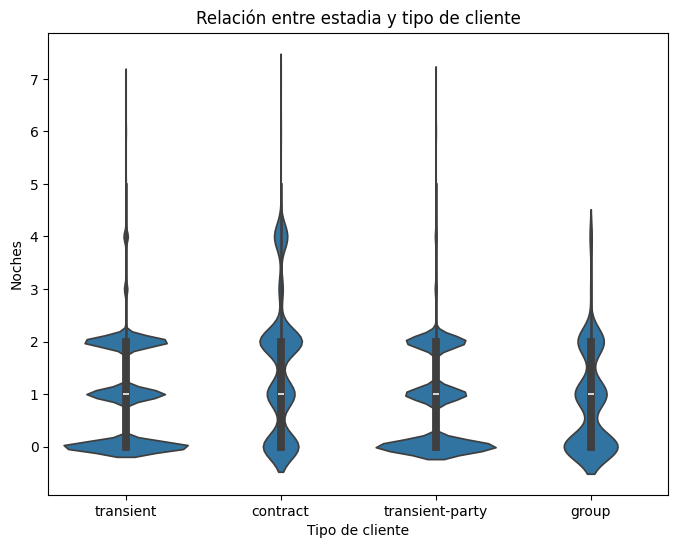

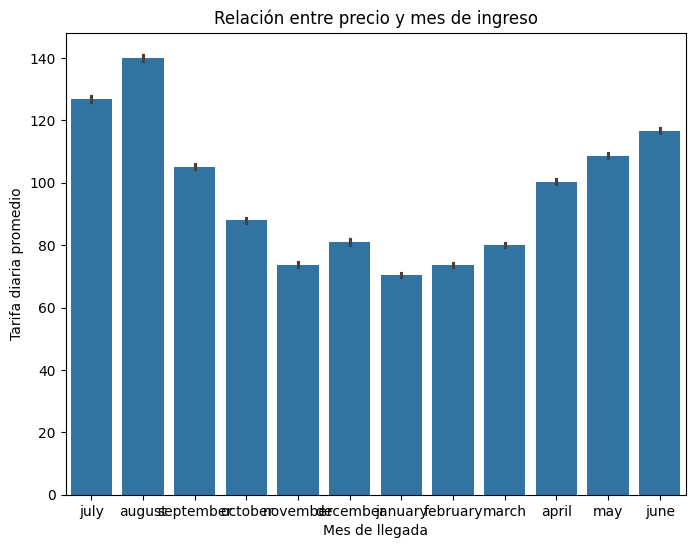

Estadísticas descriptivas:
         is_canceled      lead_time  arrival_date_year  \
count  119390.000000  119390.000000      119390.000000   
mean        0.370416      94.216995        2016.156554   
std         0.482918      90.921659           0.707476   
min         0.000000       0.000000        2015.000000   
25%         0.000000      18.000000        2016.000000   
50%         0.000000      69.000000        2016.000000   
75%         1.000000     149.000000        2017.000000   
max         1.000000     365.000000        2017.000000   

       arrival_date_week_number  arrival_date_day_of_month  \
count             119390.000000              119390.000000   
mean                  27.165173                  15.798241   
std                   13.605138                   8.780829   
min                    1.000000                   1.000000   
25%                   16.000000                   8.000000   
50%                   28.000000                  16.000000   
75%             

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Cargar el archivo CSV para inspeccionarlo
archivo = '/content/hotel_bookings.csv'
data = pd.read_csv(archivo)

# Verificar las primeras filas del dataset
data.head()
# Verificar si hay valores duplicados
duplicados = data.duplicated().sum()
# Eliminar duplicados y contar el número de filas antes y después de la eliminación
filas_antes = data.shape[0]
data_sin_duplicados = data.drop_duplicates()
filas_despues = data_sin_duplicados.shape[0]

duplicados, filas_antes, filas_despues

# Función para detectar columnas categóricas
def detectar_columnas_categoricas(data):
    return data.select_dtypes(include=['object']).columns
# Función para corregir inconsistencias en valores categóricos
def corregir_inconsistencias(data, columnas):
    for columna in columnas:
        data[columna] = data[columna].str.lower()  # Convertir a minúsculas
        data[columna] = data[columna].str.strip()  # Eliminar espacios en blanco
        # Reemplazar valores inconsistentes
        valores_inconsistentes = {
            'yes ': 'yes',
            'no ': 'no',
            'y': 'yes',
            'n': 'no',
            'si': 'yes',
            'no': 'no',
            'sí': 'yes',
        }
        data[columna] = data[columna].replace(valores_inconsistentes)
    return data
# Detectar columnas categóricas
columnas_categóricas = detectar_columnas_categoricas(data)
print("Columnas categóricas detectadas:", columnas_categóricas)
# Corregir inconsistencias
data = corregir_inconsistencias(data, columnas_categóricas)
data.info()

# investigandao valores faltantes
print(data.isnull().sum())
# completanto con 0 los valores NaN en children
data['children']=data['children'].fillna(0)
#Llenar los valores nulos de la columna 'country' con moda
x=data['country'].mode()
print(x)
data['country']=data['country'].fillna('PRT')
## Rellenar valores numéricos nulos con la mediana
data[['agent','company']]=data[['agent','company']].fillna(data[['agent','company']].median())
# volviendo a investigar si aun hay valores nulos
print(data.isna().sum())

# Identificar datos anómalos
def identificar_datos_anomalos(data):
    # Establecer umbrales para detectar valores extremos
    umbrales = {
       'lead_time': (0, 365),  # considerando tiempo de anticipación para la reserva (más de 1 año es anómalo)
        'stays_in_weekend_nights': (0, 7),  # Número de noches de estancia en fines de semana (más de 7 noches es anómalo)
        'stays_in_week_nights': (0, 14),  # Número de noches de estancia entre semana (más de 14 noches es anómalo)
        'adults': (1, 10),  # Número de adultos en la reserva (menos de 1 o más de 10 es anómalo)
        'children': (0, 5),  # Número de niños en la reserva (más de 5 niños es anómalo)
        'babies': (0, 2),  # Número de bebés en la reserva (más de 2 bebés es anómalo)
        'is_repeated_guest': (0, 1),  # Indicador de huésped repetido (valor distinto de 0 o 1 es anómalo)
        'previous_cancellations': (0, 5),  # Número de cancelaciones previas (más de 5 cancelaciones es anómalo)
        'booking_changes': (0, 3),  # Número de cambios en la reserva (más de 3 cambios es anómalo)
        'days_in_waiting_list': (0, 30),  # Días en lista de espera (más de 30 días es anómalo)
        'adr': (0, 500)  # Tarifa diaria promedio (menos de 0 o más de 500 USD es anómalo)
    }
    # Identificar datos anómalos
    datos_anomalos = {}
    for columna, umbral in umbrales.items():
        datos_anomalos[columna] = data[(data[columna] < umbral[0]) | (data[columna] > umbral[1])]
    return datos_anomalos
# Identificar datos anómalos
datos_anomalos = identificar_datos_anomalos(data)

# Corregir datos anómalos
def corregir_datos_anomalos(data, datos_anomalos):
    # Establecer estrategias de corrección
    estrategias_correccion = {
        'lead_time': lambda x: x.median(),  # Reemplazar con la mediana para evitar sesgos
        'stays_in_weekend_nights': lambda x: x.median(),  # Reemplazar con la mediana para evitar sesgos
        'stays_in_week_nights': lambda x: x.median(),  # Reemplazar con la mediana para evitar sesgos
        'adults': lambda x: 1,  # Establecer en 1 adulto como mínimo
        'children': lambda x: 0,  # Establecer en 0 niños como valor default
        'babies': lambda x: 0,  # Establecer en 0 bebés como valor default
        'is_repeated_guest': lambda x: 0,  # Establecer en 0 para indicar no es huésped repetido
        'previous_cancellations': lambda x: 0,  # Establecer en 0 cancelaciones previas
        'booking_changes': lambda x: 0,  # Establecer en 0 cambios en la reserva
        'days_in_waiting_list': lambda x: 0,  # Establecer en 0 días en lista de espera
        'adr': lambda x: x.median(),  # Reemplazar con la mediana para evitar sesgos
        'hotel': lambda x: 'Desconocido',  # Establecer en "Desconocido" para evitar información incorrecta
        'arrival_date_year': lambda x: pd.Timestamp.today().year,  # Establecer en el año actual
        'arrival_date_month': lambda x: pd.Timestamp.today().month,  # Establecer en el mes actual
        'arrival_date_day_of_month': lambda x: pd.Timestamp.today().day,  # Establecer en el día actual
        'arrival_date_day_of_week': lambda x: pd.Timestamp.today().weekday(),  # Establecer en el día de la semana actual
        'distribution_channel': lambda x: 'Otros',  # Establecer en "Otros" para evitar información incorrecta
        'market_segment': lambda x: 'Otros',  # Establecer en "Otros" para evitar información incorrecta
        'meal': lambda x: 'Otros',  # Establecer en "Otros" para evitar información incorrecta
        'customer_type': lambda x: 'Otros',  # Establecer en "Otros" para evitar información incorrecta
        'reservation_status': lambda x: 'Confirmada',  # Establecer en "Confirmada" para evitar información incorrecta
        'reservation_status_date': lambda x: pd.Timestamp.today()  # Establecer en la fecha actual
    }

    # Corregir datos anómalos
    for columna, datos in datos_anomalos.items():
        data.loc[datos.index, columna] = estrategias_correccion[columna](data[columna])
    return data

# Corregir datos anómalos
data = corregir_datos_anomalos(data, datos_anomalos)

# Verificar que no queden datos anómalos
datos_anomalos = identificar_datos_anomalos(data)
print("Datos anómalos después de corregir:")
print(datos_anomalos)



# Visualizaciones univariadas
# 1. Distribución de estancias
plt.figure(figsize=(8, 6))
sns.histplot(data['stays_in_weekend_nights'], kde=True)
plt.title('Distribución de estadias ingresando fines de semana')
plt.xlabel('Noches')
plt.ylabel('Frecuencia')
plt.show()
# Interpretación: La mayoría de los huéspedes se quedan entre 1-2 noches si ingresaron un fin de semana.

# 2. Gráfico de barras de tipos de huéspedes
plt.figure(figsize=(8, 6))
sns.countplot(x='customer_type', data=data)
plt.title('Distribución de tipos de huéspedes')
plt.xlabel('Tipo de huésped')
plt.ylabel('Frecuencia')
plt.show()
# Interpretación: La mayoría de los huéspedes son de tipo "Transient".

# Visualizaciones multivariadas
# 1. Relación entre estancias y tipo de cliente
plt.figure(figsize=(8, 6))
sns.violinplot(x='customer_type', y='stays_in_weekend_nights', data=data)
plt.title('Relación entre estadia y tipo de cliente')
plt.xlabel('Tipo de cliente')
plt.ylabel('Noches')
plt.show()
# Interpretación:
# - Los clientes transitorios presentan una mayor variabilidad en la duración de su estancia.
# - Los clientes corporativos tienden a quedarse más noches.


# 2. Relación entre precio y mes de llegada
plt.figure(figsize=(8, 6))
sns.barplot(x='arrival_date_month', y='adr', data=data)
plt.title('Relación entre precio y mes de ingreso')
plt.xlabel('Mes de llegada')
plt.ylabel('Tarifa diaria promedio')
plt.show()

# Interpretación:
# - Se observa un patrón estacional claro, con precios más altos durante los meses de
#   junio, julio y agosto.
# - Durante los meses de invierno, los precios son significativamente más bajos.


# Estadísticas descriptivas
estadisticas = data.describe()
print("Estadísticas descriptivas:")
print(estadisticas)

# Identificación de tendencias
# La mayoría de los huéspedes se quedan entre 1 y 2 noches en fines de semana.
# Durante los meses de invierno, los precios son significativamente más bajos
# Los clientes corporativos tienden a quedarse más noches.